<a href="https://colab.research.google.com/github/johnbuild/tfagents/blob/master/190316_tfagents_berater_v12_dqn_openai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Berater Environment v13

## Changes from v12 (work in progress)
* port to tfagents with dqn
* includes original openai beraterv12 implementation

In [0]:
num_iterations = 20000  # @param

initial_collect_steps = 50  # @param
collect_steps_per_iteration = 1  # @param
replay_buffer_capacity = 100000  # @param

fc_layer_params = (100,)

batch_size = 64  # @param
learning_rate = 1e-3  # @param
log_interval = 500  # @param

num_eval_episodes = 10  # @param
eval_interval = 1000  # @param

## Install tf-agents

In [0]:
!pip install tf-agents-nightly > /dev/null
!pip install tf-nightly > /dev/null

# Define Environment

### Imports

In [0]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces


### Helper methods

In [0]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [0]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())
        if self.stepCount >= 200:
          if BeraterEnv.showDone:
            print("Done: stepCount >= 200")
          done = True

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [0]:
BeraterEnv.showStep = False
BeraterEnv.showDone = False

### Register with OpenAI Gym

In [0]:
if not 'isEnvRegistered' in locals():
  env_id="Berater-v1"
  gym.envs.registration.register(id=env_id,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_id + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


# TF-Agents: Train, enjoy, evaluate

### Imports & Helpers

In [0]:
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.dqn import q_network
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import trajectory
from tf_agents.metrics import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()


In [0]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


### Setup tf-agent envs, models, policies & agents

In [0]:
env_name="Berater-v1"
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [0]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

tf_agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=dqn_agent.element_wise_squared_loss,
    train_step_counter=train_step_counter)
tf_agent.initialize()

In [0]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [0]:
avg_rnd_return = compute_avg_return(eval_env, random_policy, num_eval_episodes)
print("avgerage return with random policy={}".format(avg_rnd_return))

avgerage return with random policy=-6.630001068115234


### Setup replay buffer (train_env)

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)
print("replay buffer batch_size=" + str(train_env.batch_size) + \
      " max_length=" + str(replay_buffer_capacity) + \
      " size=" + str(replay_buffer.gather_all().observation.shape[1])
     )

replay buffer batch_size=1 max_length=100000 size=0


In [0]:
#@test {"skip": true}
def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  # print("collect_step: trajectory=" + str(traj))

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

In [0]:
replay_buffer_size=replay_buffer.gather_all().observation.shape[1]
print("replay_buffer size=" + str(replay_buffer_size) + " capacity=" + str(replay_buffer_capacity))

replay_buffer size=0 capacity=100000


In [0]:
print("initial_collect_steps=" + str(initial_collect_steps))
for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

replay_buffer_size=replay_buffer.gather_all().observation.shape[1]
print("replay_buffer size=" + str(replay_buffer_size) + " capacity=" + str(replay_buffer_capacity))


initial_collect_steps=50
replay_buffer size=50 capacity=100000


In [0]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size, num_steps=2).prefetch(3)

iterator = iter(dataset)

In [0]:
# print(iterator.next()[0].action)

### Train the agent

In [0]:
#@test {"skip": true}
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]
print("retuns={} (before training) num_eval_episodes={}".format(returns,num_eval_episodes))

retuns=[-24.814976] num_eval_episodes=10
CPU times: user 6.83 s, sys: 199 ms, total: 7.02 s
Wall time: 6.94 s


In [0]:
#@test {"skip": true}
%%time

for _ in range(num_iterations):

  # Collect one step using collect_policy and save to the replay buffer.
  collect_step(train_env, tf_agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = tf_agent.train(experience)

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 10: loss = 8786.876953125
step = 20: loss = 9771.107421875
step = 30: loss = 4586.8759765625
step = 40: loss = 13560.931640625
step = 50: loss = 20443.58984375
step = 60: loss = 24458.505859375
step = 70: loss = 20240.396484375
step = 80: loss = 38077.3671875
step = 90: loss = 121028.8828125
step = 100: loss = 28873.232421875
step = 100: Average Return = -32.994956970214844
step = 110: loss = 132478.515625
step = 120: loss = 265384.125
step = 130: loss = 174302.09375
step = 140: loss = 204785.203125
step = 150: loss = 392971.65625
step = 160: loss = 1118498.125
step = 170: loss = 128556.078125
step = 180: loss = 1021347.5
step = 190: loss = 1017544.125
step = 200: loss = 935455.0
step = 200: Average Return = -32.816627502441406
step = 210: loss = 253966.0625
step = 220: loss = 1011911.5
step = 230: loss = 1371143.5
step = 240: loss = 1714275.375
step = 250: loss = 1253881.5
step = 260: loss = 1582263.625
step = 270: loss = 4020013.5
step = 280: loss = 2624180.75
step = 290: loss

### Visualize training rewards

In [0]:
print("num_iterations={} eval_interval={} tf_agent: train_step_counter={} train_sequence_length={}".format(\
                 num_iterations, \
                 eval_interval, \
                 tf_agent.train_step_counter.numpy(), \
                 tf_agent.train_sequence_length))
print("returns={}".format(returns))


num_iterations=2000 eval_interval=100 tf_agent: train_step_counter=2000 train_sequence_length=2
returns=[-24.814976, -32.994957, -32.816628, -29.696634, -32.833294, -32.799957, -32.766624, -32.883293, -32.866627, -25.023304, -9.621661, -17.498316, -17.07998, -10.978338, -27.643301, -17.096647, -9.554994, -17.163317, -9.028345, -10.325, -10.643335]


NameError: ignored

(-34.19328756332398, 250)

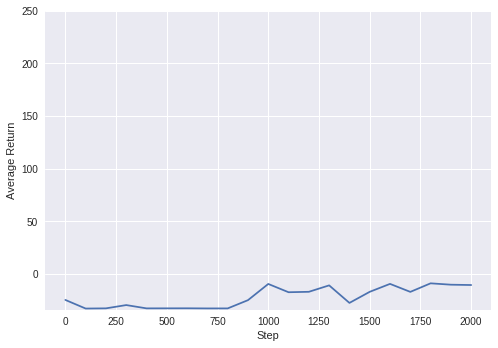

In [0]:
#@test {"skip": true}
import matplotlib
import matplotlib.pyplot as plt


steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=250)

# Test Environment (OpenAI Gym)

In [0]:
env = BeraterEnv()
print(env.reset())
print(env.customer_reward)

In [0]:
BeraterEnv.showStep = True
BeraterEnv.showDone = True

env = BeraterEnv()
print(env)
observation = env.reset()
print(observation)

for t in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
print(observation)

## Baseline

In [0]:
from copy import deepcopy
import json

class Baseline():

  def __init__(self, env, verbose=1):
    self.env = env
    self.verbose = verbose
    self.reset()

  def reset(self):
    self.map = self.env.map
    self.rewards = self.env.customer_reward.copy()
    
  def as_string(self, state):
    # reward/cost does not hurt, but is useless, path obsucres same state
    new_state = {
        'rewards': state['rewards'],
        'position': state['position']
    }
    return json.dumps(new_state, sort_keys=True)
  
  def is_goal(self, state):
    if state['position'] != 'S': return False
    for reward in state['rewards'].values():
      if reward != 0: return False
    return True
    

  def expand(self, state):
    states = []
    for position, cost in self.map[state['position']]:
      new_state = deepcopy(state)
      new_state['position'] = position
      new_state['rewards'][position] = 0
      reward = state['rewards'][position]
      new_state['reward'] += reward
      new_state['cost'] += cost
      new_state['path'].append(position)
      states.append(new_state)
    return states

  def search(self, root, max_depth = 25):
      closed = set()
      open = [root]

      while open:
          state = open.pop(0)
          if self.as_string(state) in closed: continue  

          closed.add(self.as_string(state))

          depth = len(state['path'])
          if depth > max_depth:
            if self.verbose > 0:
              print("Visited:", len(closed))
              print("Reached max depth, without reaching goal")
            return None

          if self.is_goal(state):
            scaled_reward = (state['reward'] - state['cost']) / 6000
            state['scaled_reward'] = scaled_reward
            if self.verbose > 0:
              print("Scaled reward:", scaled_reward)            
              print("Perfect path", state['path'])
            return state

          expanded = self.expand(state)
          open += expanded
          # make this best first
          open.sort(key=lambda state: state['cost'])
        
  def find_optimum(self):
    initial_state = {
        'rewards': self.rewards.copy(),
        'position': 'S',
        'reward': 0,
        'cost': 0,
        'path': ['S']
    }
    return self.search(initial_state)
  
  def benchmark(self, model, sample_runs=100):
    self.verbose = 0
    BeraterEnv.showStep = False
    BeraterEnv.showDone = False

    perfect_rewards = []
    model_rewards = []
    for run in range(sample_runs):
      observation = self.env.reset()
      self.reset()
      
      optimum_state = self.find_optimum()
      perfect_rewards.append(optimum_state['scaled_reward'])
      
      state = np.zeros((1, 2*128))
      dones = np.zeros((1))

      for t in range(1000):
        actions, _, state, _ = model.step(observation, S=state, M=dones)
        observation, reward, done, info = self.env.step(actions[0])
        if done:
          break
      model_rewards.append(env.totalReward)
    return perfect_rewards, model_rewards
  
  def score(self, model, sample_runs=100):
    perfect_rewards, model_rewards = self.benchmark(model, sample_runs=100)
    
    perfect_score_mean, perfect_score_std = np.array(perfect_rewards).mean(), np.array(perfect_rewards).std()
    test_score_mean, test_score_std = np.array(model_rewards).mean(), np.array(model_rewards).std()
    
    return perfect_score_mean, perfect_score_std, test_score_mean, test_score_std

# OpenAI: Train, enjoy & evaluate model

## Train model

Estimation
* total cost when travelling all paths (back and forth): 2500
* all rewards: 6000
* but: rewards are much more sparse while routes stay the same, maybe expect less
* estimate: no illegal moves and between
  * half the travel cost: (6000 - 1250) / 6000 = .79
  * and full traval cost (6000 - 2500) / 6000 = 0.58
* additionally: the agent only sees very little of the whole scenario
  * changes with every episode
  * was ok when network can learn fixed scenario


In [0]:
!rm -r logs
!mkdir logs
!mkdir logs/berater

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

In [0]:
%%time

# https://github.com/openai/baselines/blob/master/baselines/deepq/experiments/train_pong.py
# log_dir = logger.get_dir()
log_dir = '/content/logs/berater/'

import gym
from baselines import bench
from baselines import logger

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.vec_monitor import VecMonitor
from baselines.ppo2 import ppo2
from baselines.a2c import a2c

BeraterEnv.showStep = False
BeraterEnv.showDone = False

env = BeraterEnv()

wrapped_env = DummyVecEnv([lambda: BeraterEnv()])
monitored_env = VecMonitor(wrapped_env, log_dir)

# https://github.com/openai/baselines/blob/master/baselines/ppo2/ppo2.py
# https://github.com/openai/baselines/blob/master/baselines/common/models.py#L30
# https://arxiv.org/abs/1607.06450 for layer_norm

# lr linear from lr=1e-2 to lr=1e-4 (default lr=3e-4)
def lr_range(frac):
  # we get the remaining updates between 1 and 0
  start_lr = 1e-2
  end_lr = 1e-4
  diff_lr = start_lr - end_lr
  lr = end_lr + diff_lr * frac
  return lr

def mlp(num_layers=2, num_hidden=64, activation=tf.nn.relu, layer_norm=False):
    def network_fn(X):
        h = tf.layers.flatten(X)
        for i in range(num_layers):
            h = tf.layers.dense(h, units=num_hidden, kernel_initializer=tf.initializers.glorot_uniform(seed=17))
            if layer_norm:
              h = tf.contrib.layers.layer_norm(h, center=True, scale=True)
            h = activation(h)
        return h

    return network_fn
  
network = mlp(num_hidden=500, num_layers=3, layer_norm=True)

# Parameters
# https://github.com/openai/baselines/blob/master/baselines/a2c/a2c.py
model = a2c.learn(
    env=monitored_env,
    network=network,
    gamma=1.0,
    ent_coef=0.05,
    log_interval=50000,
    total_timesteps=1000000)


# model.save('berater-ppo-v12.pkl')
monitored_env.close()

In [0]:
# !ls -l $log_dir

### Visualizing Results

https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

## Enjoy model

In [0]:
import numpy as np 

observation = env.reset()
env.render()
baseline = Baseline(env)

In [0]:
from baselines.common import plot_util as pu
results = pu.load_results(log_dir)

import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.ylim(0, .75)
# plt.plot(np.cumsum(r.monitor.l), r.monitor.r)
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=100))

In [0]:
state = np.zeros((1, 2*128))
dones = np.zeros((1))

BeraterEnv.showStep = True
BeraterEnv.showDone = False

for t in range(1000):
    actions, _, state, _ = model.step(observation, S=state, M=dones)
    observation, reward, done, info = env.step(actions[0])
    if done:
        print("Episode finished after {} timesteps, reward={}".format(t+1, env.totalReward))
        break
env.close()

In [0]:
%time baseline.find_optimum()

## Evaluation

In [0]:
baseline = Baseline(env)
perfect_score_mean, perfect_score_std, test_score_mean, test_score_std = baseline.score(model, sample_runs=100)

In [0]:
# perfect scores
perfect_score_mean, perfect_score_std

In [0]:
# test scores for our model
test_score_mean, test_score_std